In [2]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\hyli\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal

In [17]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Split 
# ----------------------------------------------------------------------------------------------------------
grating_list = [crystal.SinusoidalPhaseGrating(),
                crystal.SinusoidalPhaseGrating()]

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Delay
# ----------------------------------------------------------------------------------------------------------

# Some meta data for the delay line.
reflect_num = 4
h_length = 2. * np.pi / (1.9201 * 1e-4)
hlen_vals = np.array([h_length,] * reflect_num)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset = np.arctan(1e-3) 
delta = 13e-6
bragg_angle = np.radians(18.836) + delta

theta = bragg_angle + np.pi / 2.
theta_vals = np.array([theta, np.pi + theta , - theta , np.pi - theta ]) + angle_offset

rho = bragg_angle - np.pi / 2.
rho_vals = np.array([rho, np.pi + rho, - rho, np.pi - rho]) + angle_offset

tau_vals = np.array([0., np.radians(0.), - np.radians(0.), 0.])

# Set up the surface position
surface_points = [np.zeros(3, dtype=np.float64) for x in range(reflect_num)]

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num = reflect_num,
                                                  hlen_vals = hlen_vals,
                                                  rho_vals = rho_vals,
                                                  theta_vals = theta_vals,
                                                  tau_vals = tau_vals,
                                                  surface_points=surface_points,
                                                  chi0=complex(-0.97631E-05, 0.14871E-06),
                                                  chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                                  chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                                  chih_pi=complex(0.46945E-05, -0.11201E-06),
                                                  chihbar_pi=complex(0.46945E-05, -0.11201E-06))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset = - np.arctan(1e-3) 
delta = 13e-6
bragg_angle = np.radians(18.836) + delta

theta = 1.5 * np.pi - bragg_angle
theta_vals = np.array([theta, np.pi + theta , - theta , np.pi - theta ]) + angle_offset

rho = 0.5 * np.pi - bragg_angle
rho_vals = np.array([rho, np.pi + rho, - rho, np.pi - rho]) + angle_offset

tau_vals = np.array([0., np.radians(0.), - np.radians(0.), 0.])

# Set up the surface position
surface_points = [np.zeros(3, dtype=np.float64) for x in range(reflect_num)]

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num = reflect_num,
                                                  hlen_vals = hlen_vals,
                                                  rho_vals = rho_vals,
                                                  theta_vals = theta_vals,
                                                  tau_vals = tau_vals,
                                                  surface_points=surface_points,
                                                  chi0=complex(-0.97631E-05, 0.14871E-06),
                                                  chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                                  chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                                  chih_pi=complex(0.46945E-05, -0.11201E-06),
                                                  chihbar_pi=complex(0.46945E-05, -0.11201E-06))

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Pulse 
# ----------------------------------------------------------------------------------------------------------

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()

energy_center = 10.
k_len = util.kev_to_wave_number(energy=energy_center)

my_pulse.polar = np.array([0., 1., 0.], dtype=np.complex128)

my_pulse.k0 = np.array([0., 0., k_len])
my_pulse.n = my_pulse.k0 / util.l2_norm(my_pulse.k0)
my_pulse.omega0 = k_len * util.c

my_pulse.sigma_x = 100.  # sigma_t
my_pulse.sigma_y = 100.  # sigma_t  # fs
my_pulse.sigma_z = 1.  # fs
my_pulse.sigma_mat = np.diag(np.array([my_pulse.sigma_x ** 2,
                                       my_pulse.sigma_y ** 2,
                                       my_pulse.sigma_z ** 2], dtype=np.float64))
my_pulse.sigma_mat *= util.c ** 2

magnitude_peak = 1.
my_pulse.scaling = complex(my_pulse.sigma_x * my_pulse.sigma_y *
                           my_pulse.sigma_z * (util.c ** 3), 0.) * magnitude_peak

pre_length = 1e6
my_pulse.x0 = np.array([0., 0., -pre_length])

# ----------------------------------------------------------------------------------------------------------
#                       Step 4: Arrange the crystals
# ----------------------------------------------------------------------------------------------------------
ta = 19060175
path_list_1 = [5e6 - 20e4, 
               1e5,
               3e5 + 70e4,
               1.5e5,
               6e6 + ta - 50e4,
               1]
path_list_2 = [5e6, 
               1e5, 
               3e5, 
               1.5e5, 
               6e6 + ta,
               1]

(intersect_brunch_1, 
 kout_brunch_1,
 intersect_brunch_2,
 kout_brunch_2) = lclsutil.get_light_path(pulse_obj=my_pulse, 
                                          grating_list=grating_list,
                                          crystal_list_1=crystal_list_1, 
                                          path_list_1=path_list_1, 
                                          crystal_list_2=crystal_list_2, 
                                          path_list_2=path_list_2)

# --------------------------------------------
#     Get some estimation
# --------------------------------------------
matrix = np.vstack((kout_brunch_1[-3][1:] - kout_brunch_2[-2][1:],
                    kout_brunch_1[-2][1:] - kout_brunch_2[-2][1:]))
inv_matrix = np.linalg.inv(matrix)

vector = (intersect_brunch_2[-3][1:] - intersect_brunch_1[-4][1:]
          + (sum(path_list_1[:3]) - sum(path_list_2[:4])) * kout_brunch_2[-2][1:])
lengh = inv_matrix.dot(vector)

print(inv_matrix)
print( lengh[0] / 1e4, lengh[1]/1e4 , (sum(path_list_1[:3]) - sum(path_list_2[:4]) - np.sum(lengh)) / 1e4)

[[-6.81520992e-18  9.86634894e-03]
 [-9.49223883e-05 -2.89213982e-02]]
17499.62391235882 -51296.779584635064 33832.15567227625


In [23]:
intersect_brunch_1[-1], intersect_brunch_2[-1]

(array([0.00000000e+00, 7.50974964e-03, 3.05580679e+07]),
 array([ 0.00000000e+00, -7.50976255e-03,  3.05580679e+07]))

In [18]:
print(intersect_brunch_1[-2] - intersect_brunch_2[-2], 
      util.l2_norm(intersect_brunch_1[-2] - intersect_brunch_2[-2]))

[0.00000000e+00 1.50195122e-02 3.72529030e-09] 0.015019512193248836


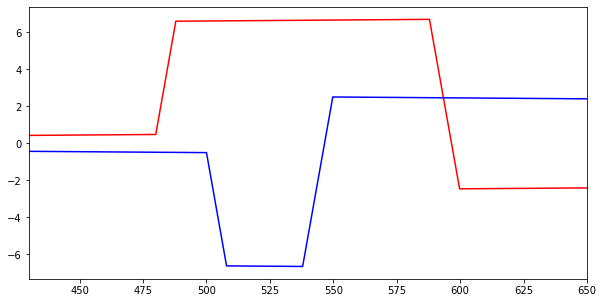

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.plot(intersect_brunch_1[:,2]/1e4, intersect_brunch_1[:,1]/1e4,'r')
axes.plot(intersect_brunch_2[:,2]/1e4, intersect_brunch_2[:,1]/1e4,'b')

axes.set_xlim([5e2-70, 5e2 + 150])

#axes.set_aspect('equal', 'datalim')

plt.show()

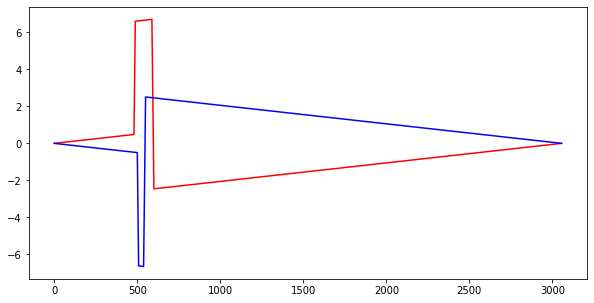

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axes.plot(intersect_brunch_1[:,2]/1e4, intersect_brunch_1[:,1]/1e4,'r')
axes.plot(intersect_brunch_2[:,2]/1e4, intersect_brunch_2[:,1]/1e4,'b')

#axes.set_ylim([-3.06, -3.04])
#axes.set_xlim([3050, 3055])
#axes.set_aspect('equal', 'datalim')

plt.show()